# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
%%time
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path='lectures.txt', data_format='vowpal_wabbit',
                                        batch_size=1000, target_folder='batches')

Wall time: 3.07 s


##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
artm_model = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={'text': 1, 'author': 1}, seed=1,
                       cache_theta=True, reuse_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
dictionary = artm.Dictionary('dictionary', data_path='lectures.txt')
dictionary.gather(batch_vectorizer.data_path)
artm_model.initialize(dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
# Ваш код
artm_model.scores.add(artm.TopTokensScore('text_token_score', num_tokens=15, class_id='text'))
artm_model.scores.add(artm.TopTokensScore('author_token_score', num_tokens=15, class_id='author'))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [8]:
# Ваш код
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer('smoothing_regularizer', tau=1e5, dictionary=dictionary,
                                                            class_ids='text', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [9]:
%%time
# Ваш код
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Wall time: 55.4 s


Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [10]:
# Ваш код
artm_model.regularizers.add(artm.SmoothSparsePhiRegularizer('thinning_regularizer', tau=-1e5, dictionary=dictionary,
                                                            class_ids='text', topic_names=topic_names[:-1]))

Выполните еще 15 проходов по коллекции.

In [11]:
%%time
# Ваш код
artm_model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

Wall time: 27.5 s


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [12]:
# Ваш код
tokens = artm_model.score_tracker['text_token_score'].last_tokens
for topic_name in artm_model.topic_names:
    print('{0} : {1}'.format(topic_name, tokens[topic_name]))

sbj0 : ['частица', 'теория', 'взаимодействие', 'физика', 'кварк', 'энергия', 'модель', 'симметрия', 'три', 'элементарный', 'нейтрино', 'стандартный', 'состоять', 'масса', 'материя']
sbj1 : ['материал', 'структура', 'при', 'температура', 'получать', 'свойство', 'химический', 'высокий', 'вещество', 'соединение', 'метод', 'элемент', 'химия', 'использовать', 'применение']
sbj2 : ['политический', 'государство', 'власть', 'царь', 'закон', 'правитель', 'партия', 'церковь', 'александр', 'сага', 'платон', 'император', 'шмитт', 'американский', 'враг']
sbj3 : ['мир', 'объект', 'знание', 'мышление', 'предмет', 'познание', 'научный', 'социологический', 'описание', 'объяснять', 'логика', 'естественный', 'признак', 'воспринимать', 'язык']
sbj4 : ['слово', 'текст', 'значение', 'словарь', 'речь', 'предложение', 'глагол', 'корпус', 'скажем', 'конструкция', 'читать', 'чтение', 'лингвистика', 'бывать', 'нужный']
sbj5 : ['миф', 'бог', 'древний', 'греческий', 'мифология', 'герой', 'представление', 'море', '

In [13]:
# Ваш код
tokens = artm_model.score_tracker['author_token_score'].last_tokens
for topic_name in artm_model.topic_names:
    print('{0} : {1}'.format(topic_name, tokens[topic_name]))

sbj0 : ['Дмитрий_Казаков', 'Михаил_Данилов', 'Валерий_Рубаков', 'Игорь_Волобуев', 'Виктор_Брагута', 'Павел_Пахлов', 'Алексей_Старобинский', 'Александр_Беленький', 'Лев_Дудко', 'Сергей_Троицкий', 'Лев_Беклемишев', 'Анатолий_Лиходед', 'Эдуард_Боос', 'Сергей_Майоров', 'Илья_Щуров']
sbj1 : ['Артем_Оганов', 'Валерий_Фокин', 'Дмитрий_Паращук', 'Валентин_Ненайденко', 'Владимир_Пудалов', 'Иван_Сорокин', 'Евгений_Гудилин', 'Дмитрий_Гольберг', 'Валентин_Крапошин', 'Алексей_Хохлов', 'Дмитрий_Клинов', 'Сергей_Морозов', 'Евгений_Антипов', 'Вадим_Бражкин', 'Владимир_Комлев']
sbj2 : ['Кирилл_Мартынов', 'Александр_Марей', 'Алексей_Юдин', 'Александр_Филиппов', 'Александр_Павлов', 'Михаил_Бойцов', 'Иван_Ладынин', 'Фёдор_Успенский', 'Дина_Гусейнова', 'Ольга_Тогоева', 'Руслан_Хестанов', 'Александр_Воеводский', 'Дмитрий_Баюк', 'Александр_Аузан', 'Юрий_Рогулёв']
sbj3 : ['Виктор_Вахштайн', 'Андрей_Кибрик', 'Григорий_Крейдлин', 'Максим_Демин', 'Татьяна_Клячко', 'Ян_Левченко', 'Гасан_Гусейнов', 'Зоя_Зорина', '

sbj27 : ['Анатолий_Засов', 'Сергей_Попов', 'Валерий_Сулейманов', 'Михаил_Ревнивцев', 'Дмитрий_Горбунов', 'Олег_Верходанов', 'Виктория_Битюкова', 'Сергей_Блинников', 'Александр_Потехин', 'Антон_Бирюков', 'Андрей_Цатурян', 'Сергей_Шишкин', 'Уолтер_Льюин', 'Мел_Сигел', 'Кирилл_Зыбин']
sbj28 : ['Александр_Павлов', 'Ивар_Максутов', 'Светлана_Баньковская', 'Елена_Вишленкова', 'Николай_Плотников', 'Павел_Соколов', 'Татьяна_Смоктунович', 'Елизавета_Ривкина', 'Александр_Кислов', 'Михаил_Эпштейн', 'Екатерина_Щербакова', 'Владимир_Каганский', 'Николай_Дронин', 'Герберт_Хупперт', 'Александр_Шварцбург']
bcg : ['Алексей_Маслов']


В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите его в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [14]:
# запишите названия тем в список
sbj_topic_labels = [
    'Физика элементарных частиц', 'Химия', 'История', 'Социология', 'Нейробиология',
    'История Древней Греции', 'Русский язык', 'История Древнего мира', 'Правоведение', 'Медицина',
    'Животноводство', 'Психология', 'История Древней Руси', 'Обществознание', 'Космология',
    'Экономика', 'Самопознание', 'Информатика', 'История Древнего Востока', 'Биология',
    'Квантовая механика', 'Литература', 'История Франции', 'История Советского Союза',
    'Лингвистика', 'Математика', 'Театр',  'Освоение космоса', 'Кино'
]
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [15]:
artm_model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = artm_model.get_theta()
phi_a = artm_model.get_phi(class_ids='author')

print('Theta:', theta.shape)
print('Phi:', phi_a.shape)

Theta: (30, 1728)
Phi: (539, 30)


In [16]:
theta.head()

,http://postnauka.ru/video/10006,http://postnauka.ru/video/10379,http://postnauka.ru/video/10380,http://postnauka.ru/video/10381,http://postnauka.ru/video/10382,http://postnauka.ru/video/10383,http://postnauka.ru/video/10384,http://postnauka.ru/video/10385,http://postnauka.ru/video/10473,http://postnauka.ru/video/10475,...,http://postnauka.ru/video/9874,http://postnauka.ru/video/9876,http://postnauka.ru/video/9968,http://postnauka.ru/video/9992,http://postnauka.ru/video/9993,http://postnauka.ru/video/9994,http://postnauka.ru/video/9995,http://postnauka.ru/video/9996,http://postnauka.ru/video/9997,http://postnauka.ru/video/9998
sbj0,0.0,0.000000,0.000000,0.000000,0.0,0.577528,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
sbj1,0.0,0.538462,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.242786,0.0,...,0.0,0.000000,0.000000,0.0,0.162022,0.0,0.0,0.0,0.0,0.0
sbj2,0.0,0.000000,0.094641,0.181199,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.227273,0.416534,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
sbj3,0.0,0.076923,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
sbj4,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.080261,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [17]:
phi_a.head()

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
Ярослав_Исполатов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Сергей_Демокритов,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.035606,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Руслан_Смелянский,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.035606,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Александр_Апт,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.816640e-08,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Людмила_Новикова,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,...,0.000000,0.0,0.0,0.056223,0.0,0.0,0.0,0.0,0.0,0.0


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

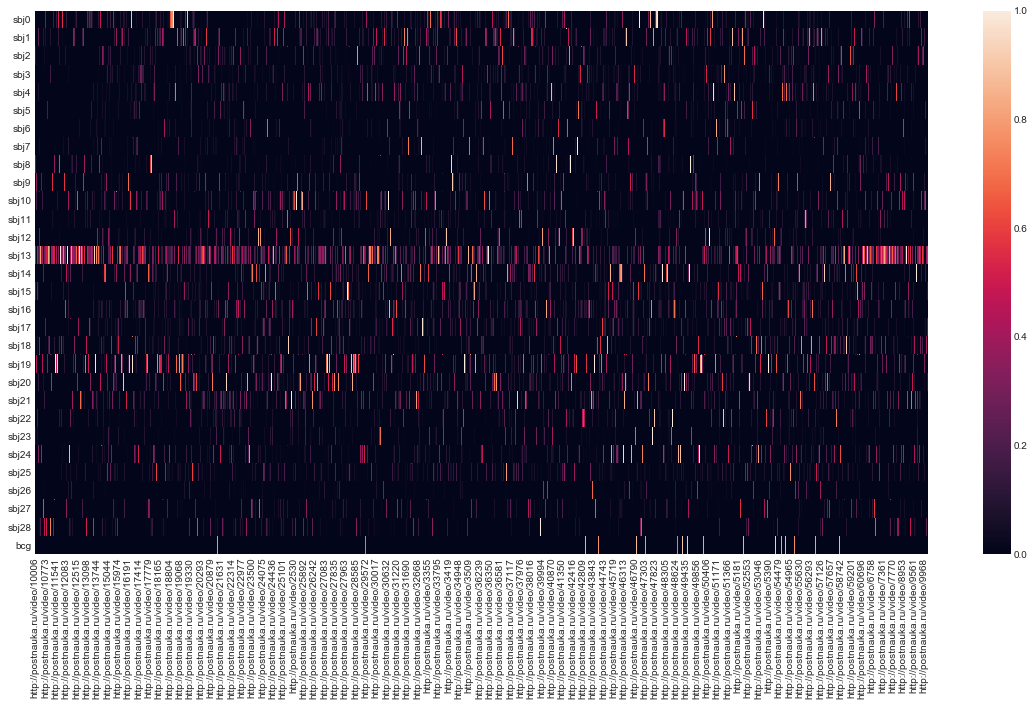

In [18]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(theta.iloc[:100])
plt.show();

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов про науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [19]:
# Ваш код
probs = [np.sum(theta.iloc[i].values) for i in range(theta.shape[0])]
probs_normed = probs / np.sum(probs)
data_theme = pd.DataFrame(probs_normed, index=topic_labels, columns=['probability'])

In [20]:
data_theme.head(30)

,probability
Физика элементарных частиц,0.039755
Химия,0.045958
История,0.025434
Социология,0.022101
Нейробиология,0.028068
История Древней Греции,0.018607
Русский язык,0.013547
История Древнего мира,0.013989
Правоведение,0.019444
Медицина,0.026969


In [21]:
data_theme.sort_values(by='probability', ascending=False)

,probability
Обществознание,0.155988
Биология,0.067672
Космология,0.050746
Квантовая механика,0.049861
Химия,0.045958
Животноводство,0.043994
Литература,0.043049
Самопознание,0.041672
Физика элементарных частиц,0.039755
История Древнего Востока,0.037159


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Ваш ответ:
* 5 тем с max p(t): *Обществознание, Биология, Космология, Квантовая механика, Химия*
* 3 темы с min p(t): *История Советского Союза, Фоновая тема, Театр*

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

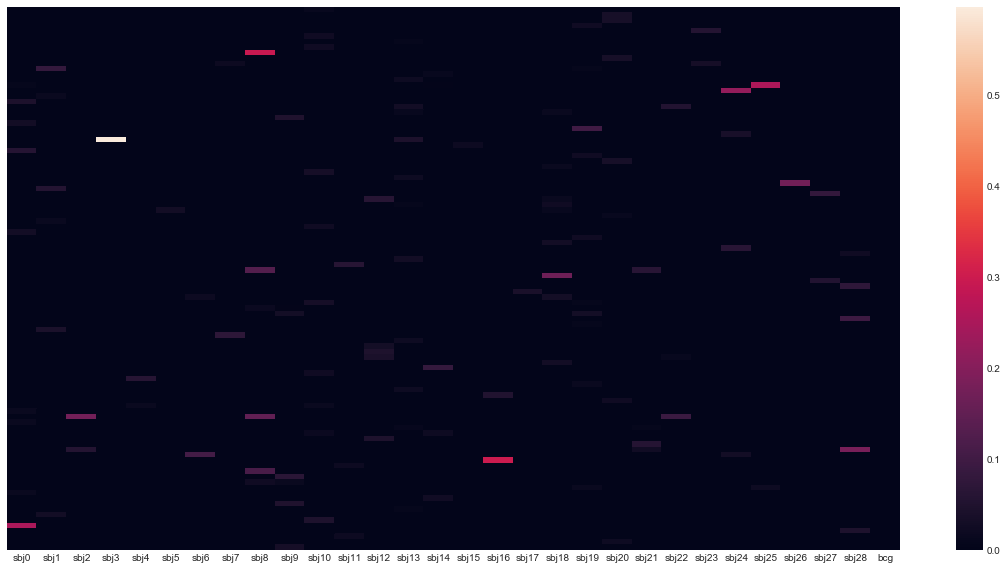

In [22]:
# Ваш код
plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a.iloc[:100], yticklabels=False)
plt.show();

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [23]:
# Ваш код
authors_valuable_topics = []

for i in range(phi_a.shape[0]):
    author_counts = 0
    
    for j in phi_a.iloc[i]:
        if j > 0.01:
            author_counts += 1
            
    authors_valuable_topics.append(author_counts)
        
data = pd.DataFrame(authors_valuable_topics, index=phi_a.index, columns=['valuable_topics'])

In [24]:
top_authors = data[data['valuable_topics'] >= 3]

top_authors.sort_values(by='valuable_topics', ascending=False)

,valuable_topics
Михаил_Алексеевский,5
Гасан_Гусейнов,4
Ян_Левченко,4
Александр_Марей,3
Александр_Павлов,3
Александр_Филиппов,3
Фёдор_Успенский,3
Николай_Дронин,3
Андрей_Чабовский,3
Павел_Нерлер_(Полян),3


In [25]:
print(top_authors.index)

Index(['Александр_Марей', 'Александр_Павлов', 'Гасан_Гусейнов',
       'Александр_Филиппов', 'Фёдор_Успенский', 'Михаил_Алексеевский',
       'Николай_Дронин', 'Ян_Левченко', 'Андрей_Чабовский',
       'Павел_Нерлер_(Полян)', 'Ольга_Вайнштейн'],
      dtype='object')


Ваш ответ:
* Авторы, значимые в не менее чем 3 темах: 'Александр Марей', 'Александр Павлов', 'Гасан Гусейнов', 'Александр Филиппов', 'Фёдор Успенский', 'Михаил Алексеевский', 'Николай Дронин', 'Ян Левченко', 'Андрей Чабовский', 'Павел Нерлер (Полян)', 'Ольга Вайнштейн'

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [26]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [27]:
# Ваш код
author_theme_probs = np.empty(phi_a.shape)

for i in range(author_theme_probs.shape[0]):
    for j in range(author_theme_probs.shape[1]):
        author_theme_probs[i, j] = phi_a.iloc[i, j] * data_theme.iloc[j, :] / np.sum(phi_a.iloc[i, :] * data_theme['probability'].values)

Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [28]:
# Ваш код
similarities = pairwise_distances(author_theme_probs, metric='cosine')
mds_model = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_data = mds_model.fit_transform(similarities)

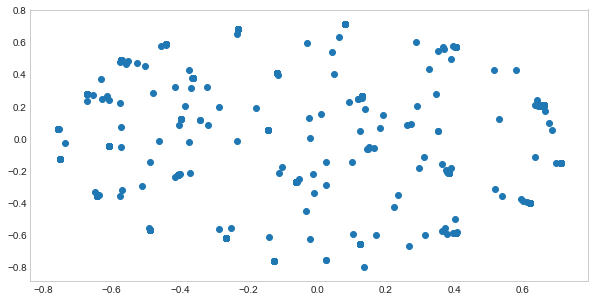

In [29]:
# Ваш код
plt.figure(figsize=(10,5))
plt.scatter(mds_data[:,0], mds_data[:,1])
plt.show();

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

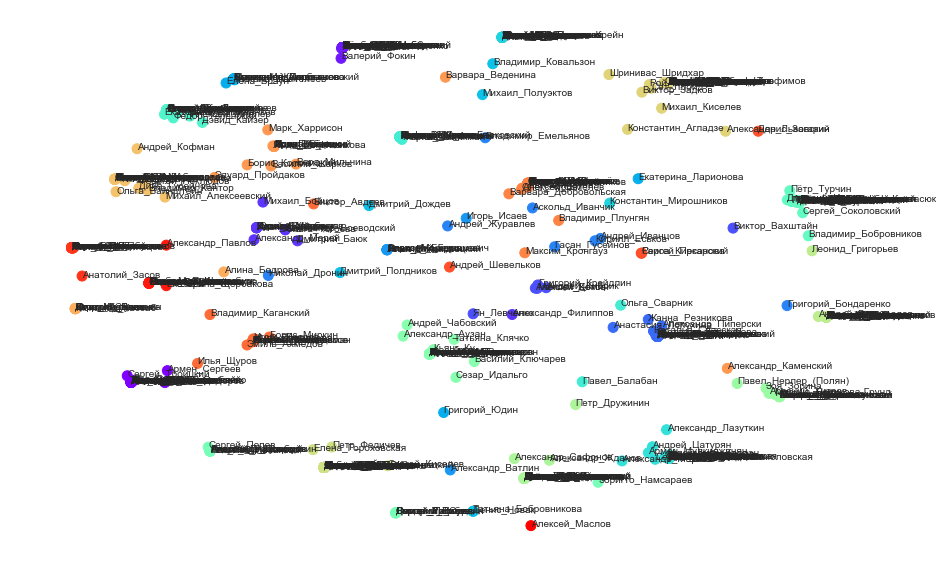

In [30]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем

# Ваш код
max_theme_prob_for_colors = [np.argmax(author) for author in author_theme_probs]

plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(mds_data[:,0], mds_data[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi_a.index):
    plt.annotate(author, mds_data[i])

plt.savefig('authors_map.pdf', dpi=200, format='pdf')
plt.show();

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [31]:
# Ваш код
pdt = theta.apply(lambda row: row / np.sum(row), axis=1)
max_prob_d = np.argmax(pdt.values, axis=1)

In [32]:
print(max_prob_d)

[ 127 1294 1505 1199 1462 1071  916 1051  183 1125  507 1456  655   50
  866  606  998  751 1580   40  307  497  514 1196 1470  913 1080  659
  979 1434]


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [33]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [34]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [35]:
# Ваш код
tokens = list(artm_model.score_tracker['text_token_score'].last_tokens.values())
top_ten_docs = [theta.iloc[i].sort_values(ascending=False)[:10].index.values for i in range(theta.shape[0])]

for i, label in enumerate(topic_labels):
    display(HTML(u"<h1>{0}</h3>".format(label)))
    display(HTML(u'{0}'.format(', '.join(tokens[i]))))
    
    for doc in top_ten_docs[i]:
        display(HTML(u'<a href="{0}">{0}</a>'.format(doc)))

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 